<a href="https://colab.research.google.com/github/juanpajedrez/pytorch_learning/blob/main/08_pytorch_paper_replicating_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Milestone Paper Replication: PyTorch Replicating Paper

The goal of machine learning research paper replicating is: turn an ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture with PyTorch:

Paper link: https://arxiv.org/pdf/2010.11929
Paper Abs: https://arxiv.org/abs/2010.11929


## 0. Get Setup
Let's import code we've previously written + required libraries.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

torch version: 2.9.0+cu126
torchvision version: 0.24.0+cu126


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
!nvidia-smi

Fri Dec 19 01:44:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             46W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT transformer architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [7]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [9]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [10]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # come from Table 3 of the ViT paper.

# Create transforms pipeline
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transform}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [11]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... we scale regarding our hardware).
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
  train_dir = train_dir,
  test_dir = test_dir,
  transform = manual_transform,
  batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto *visualize, visualize, visualize!*

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

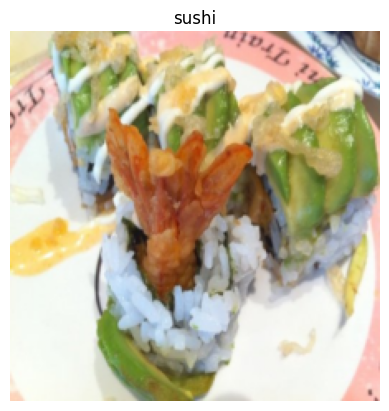

In [13]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more undeerstandable, we can break it down into smaller pieces.

* **Inputs:** - What goes into the model? (in our case, image tensors)
* **Outputs:** - What comes out of the model/layer/block> (in our case, we want the model to output image classification labels).
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers:.
* **Model** -  A collection of blocks.

### 3.1 Overview: Pieces of the puzzle.

* Figure 1: Visual Overview of the architecture
* Four Equations: Math equations which define the function of layer/block.
* Table 1/3: Different hyperparameters for the architecture/training.
* Text.


### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* Embedding = learnable representation (start with random numbers and improve them over time)

### Four equations

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]
```

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation3
x_output_MLP_block = MLP_layer(LN_Layer(x_output_MSA_block)) + x_output_MSA_block
```

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = feed forward neural network with N number of layers.
* MLP = one hidden layer at a time.
* MLP = single line layer at fine-tuning time.

In pseudocode:
```python
# Equation 4
y = MLP(LN_Layer(x_output_MLP_block))
```

### Table 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large, and ViT Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture.
* MLP size - the number of hidden units/neurons in the MLP.
* Head - the number of multi-head self-attention.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?`

* Input shape: (224, 224, 3) -> Single image -> (height, width, colour_channels)
* Output Shape: ??

### 4.1 Calculate input and output shapes by hand

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input image: $H\times{W}\times{C}$ (height x width x color_channels)
* Output Image: $\mathbb{R}^{N \times\left(P^2 \cdot C\right)}$
* H = height
* W = width
* C = color_channels
* P = pathc size
* N = number of patches = (heigth * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [14]:
# Create example values
height = 224
width = 224
colour_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [15]:
# Input shape
embedding_layer_input_shape = (height, width, colour_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * colour_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_patches, embedding_dimension)


### 4.2 Turning a single image into patches

Let's visualize, visualize, visualize!

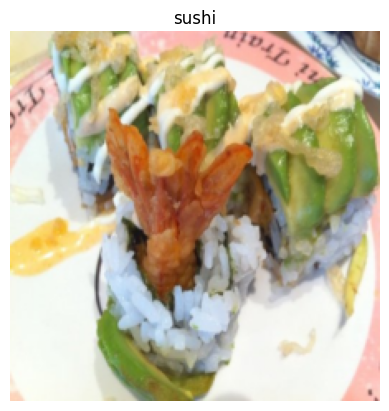

In [16]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
image.shape

torch.Size([3, 224, 224])

torch.Size([224, 224, 3])


(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

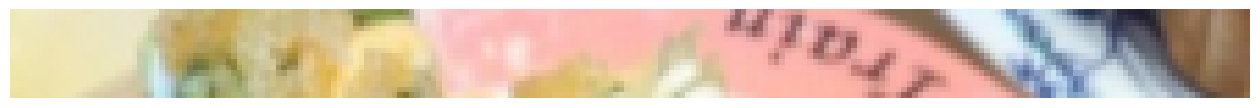

In [18]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert images to color channels last  (C, H, W) -> (H, W, C)
print(image_permuted.shape)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
plt.axis(False)

Number of patches per row: 14.0
 Patch_size: 16
 pixels x 16 pixels


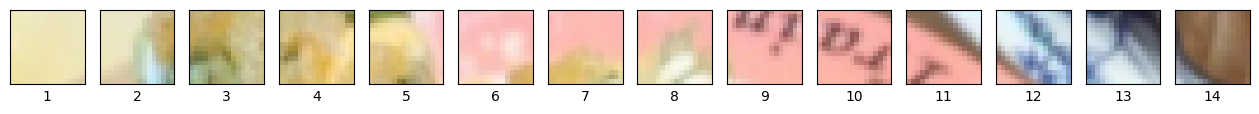

In [19]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\n Patch_size: {patch_size}\n pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols=img_size//patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])
plt.show()

Number of patches per row: 14.0
Number of patches per column: 14.0
Number of total patches: 196.0
Patch_size: 16 pixels x 16 pixels


Text(0.5, 0.98, 'sushi -> Patchified')

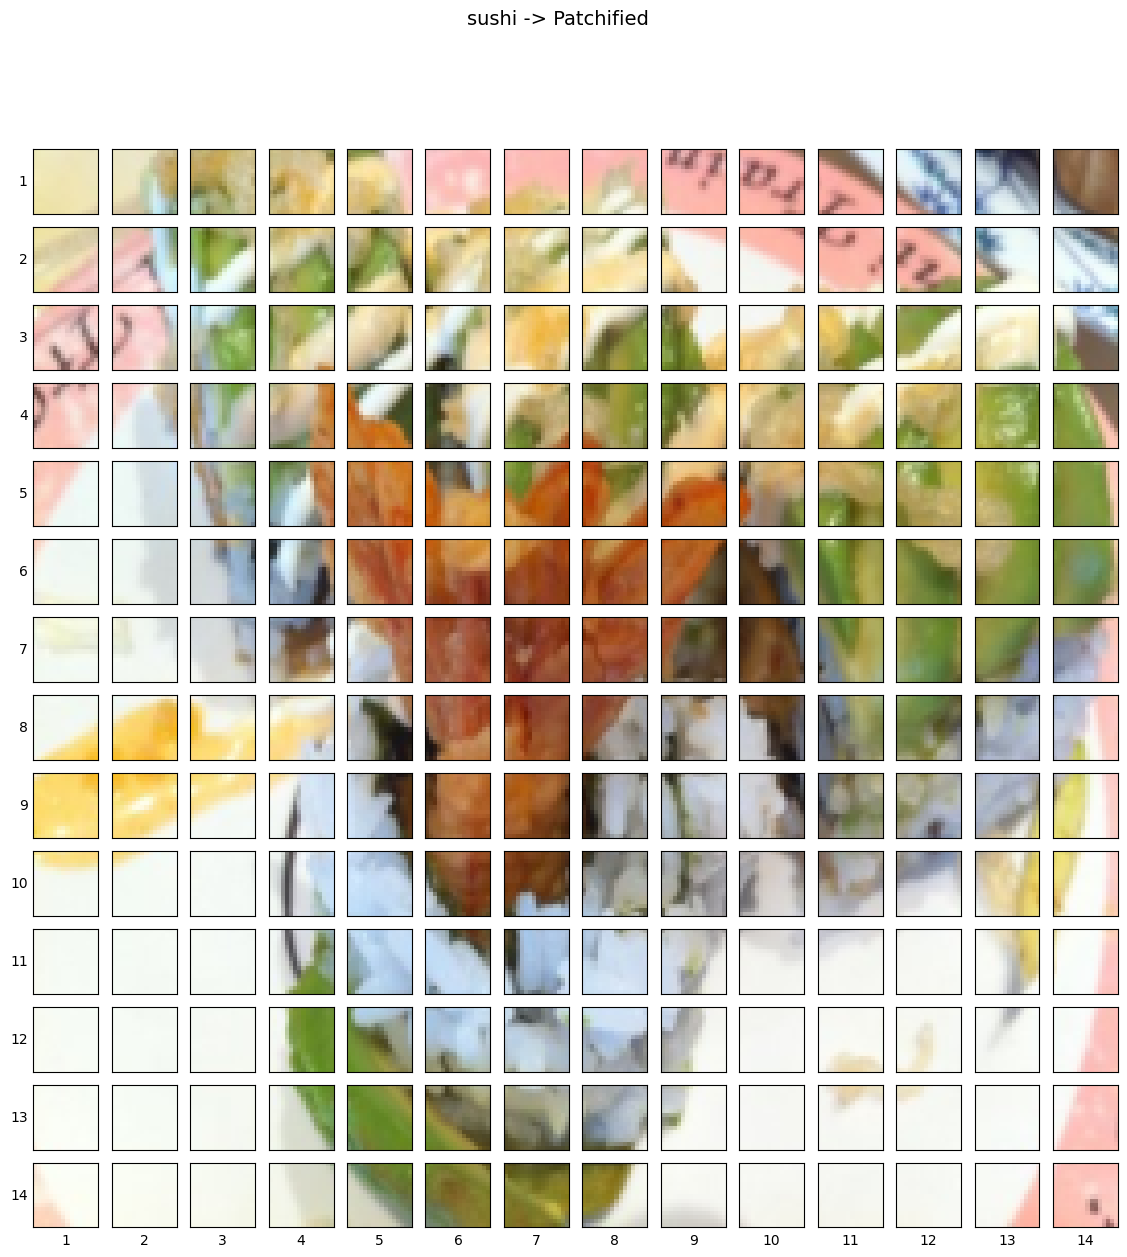

In [20]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisilbe by patch size"
print(f"Number of patches per row: {num_patches}")
print(f"Number of patches per column: {num_patches}")
print(f"Number of total patches: {num_patches**2}")
print(f"Patch_size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows = int(img_size / patch_size),
                        ncols = int(img_size / patch_size),
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
    # Plot the permuted image on the different axis
    img_plot = image_permuted[patch_height:patch_height+patch_size, # Iterate through the height dim
                                  patch_width: patch_width + patch_size, # Iterate through the width
                                  :] # Get all the colour channels
    axs[i, j].imshow(img_plot)

    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i + 1,
                         rotation="horizontal",
                         horizontalalignment = "right",
                         verticalalignment = "center")
    axs[i, j].set_xlabel(j + 1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)

### 4.3 Creating images patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`

In [21]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels = 768, # D size from Table 1,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

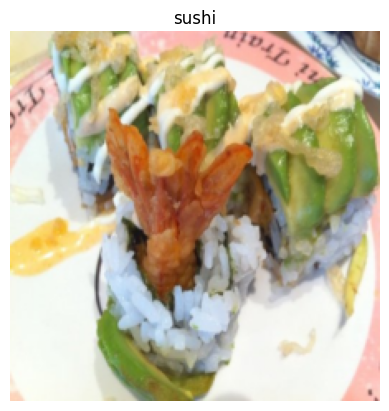

In [22]:
# Visualize single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [23]:
# Pass the image through the convolutional layer
print(image.unsqueeze(0).shape)
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])


In [24]:
14*14

196

Now we've passed a signle image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]

```

Showing random convolutional feature maps from indexes: [33, 50, 187, 304, 83]


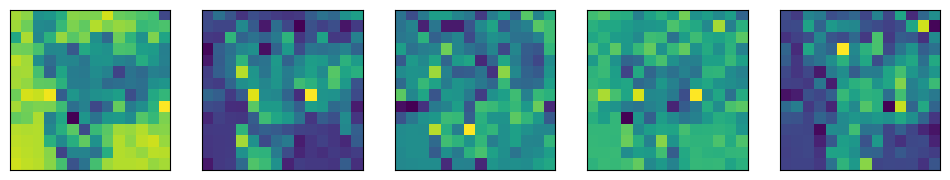

In [25]:
# Plot random convolutional feature maps
import random
random_indexes = random.sample(range(0, 768-10), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows = 1,
                        ncols = 5,
                        figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # Index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # Remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [26]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2249, -0.2346, -0.2113, -0.1639, -0.1716, -0.2313, -0.2296,
           -0.2727, -0.1800, -0.2712, -0.1938, -0.2451, -0.2827, -0.1057],
          [-0.2557, -0.2600, -0.1167, -0.0794, -0.0807, -0.1175, -0.1208,
           -0.1387, -0.2988, -0.3494, -0.2664, -0.1309,  0.0383, -0.2736],
          [-0.2627, -0.1864, -0.1377, -0.1416, -0.3389, -0.3047, -0.1771,
           -0.1463, -0.0615, -0.1460, -0.1956, -0.2085, -0.2429, -0.2089],
          [-0.1875, -0.2669, -0.1926, -0.1738,  0.0546, -0.1169, -0.0936,
           -0.0780, -0.0707, -0.1331, -0.1101, -0.0862, -0.1148, -0.1482],
          [-0.2886, -0.3002, -0.1221, -0.1449,  0.0103, -0.0839, -0.0108,
           -0.0090, -0.0564, -0.0924, -0.0335, -0.1280, -0.1117, -0.1861],
          [-0.2849, -0.2902, -0.3121, -0.1991, -0.1223, -0.0575, -0.0955,
           -0.0497, -0.0686,  0.0162, -0.1295, -0.1445, -0.0650, -0.1125],
          [-0.3028, -0.2872, -0.2826, -0.1695, -0.2302, -0.0406, -0.0905,
           -0.1172, -0.0639, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've gotten a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [27]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")


torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [28]:
from torch import nn
flatten_layer = nn.Flatten(start_dim = 2,
                           end_dim = 3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened feature map shape: torch.Size([1, 768, 196])


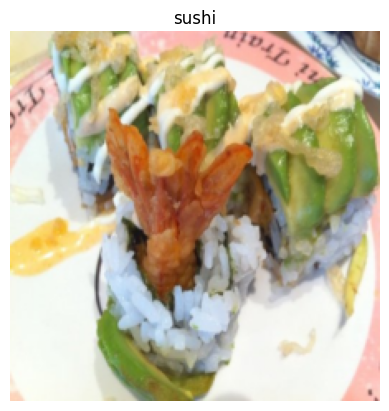

In [29]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add a batch dimension
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened feature map shape: {image_out_of_conv_flattened.shape}")


In [30]:
# Rearrange of output flattened
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dim)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

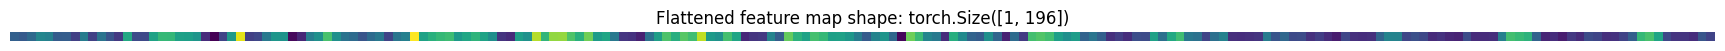

In [31]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0] # Select (batch_size, embedding_dim, single_idx_patch)
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)


### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropiate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computatoin (e.g pass through layer from 3 to 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [32]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self,
               in_channels:int = 3,
               patch_size:int = 16,
               embedding_dim: int = 768): # from Table 1 for ViT-Base
    """
    Turns a 2D input image into a 1D sequence learnable embeddinf vector.

    Args:
      in_channels (int): number of color channels for the input image. (3 for RGB)
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of the embedding dimension. Defaults to 768.
    """
    super().__init__()

    # Store all hyperparameters
    self.in_channels = in_channels
    self.patch_size = patch_size
    self.embedding_dim = embedding_dim

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Define the forward method
  def forward(self, x): # Input x is (batch_size, channel_in, height, width) -> (N, 3, 224, 224)
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by the patch size, image_shape: {image_resolution}, patch_size: {self.patch_size}"

    # Perform the forward pass
    #print(x.shape)
    x_patched = self.patcher(x)
    #print(x_patched.shape)
    x_flattened = self.flatten(x_patched)
    #print(x_flattened.shape)

    # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, num_of_pacthes, embedding_dim)
    return x_flattened.permute(0, 2, 1) # [batch_size, P^2*C, N] -> [batch_size, N, P^2*C]

In [33]:
set_seeds()

In [34]:
# Create amn instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size = 16,
                          embedding_dim=768)

# Pass a single image through embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Add an extra batch dimension
print(f"Output patch embedded image shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedded image shape: torch.Size([1, 196, 768])


In [35]:
rand_img_tensor = torch.randn(1, 3, 224, 224)
rand_img_tensor_bad = torch.randn(1, 3, 250, 250)

# Let's try them
#patchify(rand_img_tensor)
#patchify(rand_img_tensor_bad)

### 4.6 Creating a class token embedding

Want to: preprend a learnable class token to the start of the patch embedding.

In [36]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [37]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [38]:
# Create a class token embedding as a learnable parameter that shares the same size as the embedding Dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [39]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [40]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                       dim = 1) # Number of patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Class token embedding shape: {class_token.shape}")
print(f"Patch embedding image with class embedding shape {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
         [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
         ...,
         [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
         [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
         [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
       grad_fn=<CatBackward0>)
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding image with class embedding shape torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [41]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
          [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
          ...,
          [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
          [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
          [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [42]:
# Calculate the N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

# Get the embedding dimension
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dim

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(
    batch_size,
    number_of_patches + 1,
    embedding_dim),
    requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [43]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
          [ 0.0832,  1.2429,  0.7706,  ...,  1.6771,  0.5491,  1.3483],
          [ 0.2573,  1.1953,  0.6441,  ...,  1.5824,  0.6549,  1.3274],
          ...,
          [-0.0077,  1.2796,  0.7205,  ...,  1.7628,  0.5416,  1.3580],
          [ 0.0161,  1.1649,  0.8400,  ...,  1.7498,  0.4528,  1.3500],
          [ 0.0738,  1.1364,  0.8849,  ...,  1.5843,  0.5250,  1.3103]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings.

Now let's see it all in one cell.

In [44]:
# Set the seeds
set_seeds()

# Let's see our image
print(f"Original singular image: {image.shape} -> [colour_channels, height, width]") # C x H x W
height, width = image.shape[1], image.shape[2]

# Let's add a batch dimension
image_passed = image.unsqueeze(0)
print(f"Batch added singular image: {image_passed.shape} [batch_size, colour_channels, height, width]")

# Let's create our patch_embedding layer using our custom PatchEmbedding nn.module class
# in_channels = 3
# patch_size = 16
# embedding_dim = 768
patch_size = 16
patchify = PatchEmbedding(in_channels=3,
                          patch_size = patch_size,
                          embedding_dim=768)
patchified_image = patchify(image_passed)
print(f"Patchified image shape: {patchified_image.shape} -> [batch_size, num_patches, embedding_dim]")

# Obtain all the dims from the data
batch_size = patchified_image.shape[0]
num_patches = int((height * width)/patch_size**2)
embedding_dim = patchified_image.shape[-1]

# Now let's add the class token across the num_patches dimension
class_token = nn.Parameter(
    torch.randn(batch_size, 1, embedding_dim),
    requires_grad = True)

# Prepend/Concatanate it with patchified_image to make it [B x N x D] to [B x (N + 1) x D]
patchified_image_with_class_token = torch.cat((class_token, patchified_image),
                                               dim =1)
print(f"Patchified image with class token: {patchified_image_with_class_token.shape} -> [batch_size, num_patches + 1, embedding_dim]")

# Now let's create the position embedding and add it, shape must be [B x (N + 1) x D]
position_embedding = nn.Parameter(
    torch.randn(batch_size, num_patches + 1, embedding_dim),
    requires_grad=True)
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, num_patches + 1, embedding_dim]")

# Now let's add it up and voila!
patchified_image_with_class_token_and_position_embedding = patchified_image_with_class_token + position_embedding
print(patchified_image_with_class_token_and_position_embedding.shape)

Original singular image: torch.Size([3, 224, 224]) -> [colour_channels, height, width]
Batch added singular image: torch.Size([1, 3, 224, 224]) [batch_size, colour_channels, height, width]
Patchified image shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_dim]
Patchified image with class token: torch.Size([1, 197, 768]) -> [batch_size, num_patches + 1, embedding_dim]
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, num_patches + 1, embedding_dim]
torch.Size([1, 197, 768])


## Equation 2: Multihead Self-attention MSA block

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded images, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.activation.MultiheadAttention.html
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distribution of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In PyTorch = https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all of the staircase the same size.


In [46]:
class MultiHeadSelfAttentionBlock(nn.Module):
  '''
  Create a multi-head self attention block ("MSA" block for short)
  '''

  def __init__(self,
               embedding_dim:int = 768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int = 12, # Heads from Table 1 for ViT-base
               attn_dropout:int = 0): # Heads from Table 1
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first = True) # is the batch first? (batch, seq, feature) -> (batch, num_of_patches, embedding_dim)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x, # query embeddings
                                         key = x, # key embeddings
                                         value = x, # value embeddings
                                         need_weights = False)
    return attn_output

In [47]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim = 768,
    num_heads = 2,
    attn_dropout = 0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patchified_image_with_class_token_and_position_embedding)
print(f"Patched image with class token and position embedding shape: {patchified_image_with_class_token_and_position_embedding.shape}")
print(f"Patched image through MSA block: {patched_image_through_msa_block.shape}")


Patched image with class token and position embedding shape: torch.Size([1, 197, 768])
Patched image through MSA block: torch.Size([1, 197, 768])


In [48]:
patchified_image_with_class_token_and_position_embedding

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-1.6118,  0.9617, -1.3703,  ...,  0.3618, -2.6730, -0.3439],
         [-2.3282, -0.1223, -1.7570,  ...,  2.3806,  0.1627,  0.3589],
         ...,
         [ 0.2778,  1.1099, -0.1299,  ...,  0.2876,  0.8080,  1.0337],
         [-1.0245, -0.3522, -0.5089,  ...,  0.2576, -0.1969,  1.6971],
         [-1.1715,  0.1317,  1.3834,  ...,  0.1768,  1.1035, -0.0178]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[ 0.0675,  0.0819,  0.0124,  ...,  0.0419,  0.0602, -0.1997],
         [ 0.0907,  0.0776,  0.0574,  ...,  0.0349,  0.0486, -0.1897],
         [ 0.0656,  0.0458,  0.0617,  ...,  0.0364,  0.0442, -0.1959],
         ...,
         [ 0.0650,  0.0591,  0.0377,  ...,  0.0387,  0.0324, -0.1594],
         [ 0.0822,  0.0960,  0.0411,  ...,  0.0445,  0.0347, -0.1776],
         [ 0.0892,  0.0536,  0.0290,  ...,  0.0135,  0.0449, -0.1858]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perception (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1):
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, sense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear`. In TensorFlow is `tf.keras.layers.Dense()`.
  * GELU in PyTorch: https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP number of hidden units = MLP Size in Table 1
* **Dropout** = Dropout, when used, is applied after every dense layer except for the qkv-projections and directly after adding positional-to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3:

In pseudocode:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [49]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """
  Creates a layer normalized multilayer percepttron block ("MLP block" for short)
  """
  # 2 Initialize the class hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim:int = 768, # Hidden Size D from Table 1 for ViT-Base
               mlp_size:int = 3072, # MLP size from Table 1 for ViT-Base
               dropout = 0.1): # Dropout from Table 3 for ViT-Base
    super().__init__()

    # Create the norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features=mlp_size,
                  out_features = embedding_dim)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) # same as above

In [50]:
# Create an instance MLPBlock
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"patched image through MLP block: {patched_image_through_mlp_block.shape}")
print(f"patched image through MSA block: {patched_image_through_msa_block.shape}")

patched image through MLP block: torch.Size([1, 197, 768])
patched image through MSA block: torch.Size([1, 197, 768])


In [51]:
patched_image_through_mlp_block

tensor([[[ 0.3863,  0.1915, -0.1054,  ..., -0.0377,  0.1786,  0.1200],
         [ 0.2503,  0.2489, -0.2039,  ..., -0.0446,  0.2033,  0.1209],
         [ 0.3648,  0.3055, -0.1318,  ...,  0.0447,  0.2402,  0.1983],
         ...,
         [ 0.2630,  0.1361, -0.2395,  ..., -0.1586,  0.1080,  0.1689],
         [ 0.2946,  0.1948, -0.0856,  ...,  0.0947,  0.1283, -0.0118],
         [ 0.3332,  0.1005, -0.1940,  ...,  0.0284,  0.1039,  0.1685]]],
       grad_fn=<ViewBackward0>)

In [52]:
patched_image_through_msa_block

tensor([[[ 0.0893,  0.1121,  0.0298,  ...,  0.0752,  0.0660, -0.3146],
         [ 0.1076,  0.1058,  0.0685,  ...,  0.0702,  0.0512, -0.3051],
         [ 0.0958,  0.0780,  0.0781,  ...,  0.0643,  0.0533, -0.3119],
         ...,
         [ 0.0930,  0.0910,  0.0609,  ...,  0.0748,  0.0366, -0.2771],
         [ 0.1108,  0.1230,  0.0576,  ...,  0.0805,  0.0424, -0.2859],
         [ 0.1207,  0.0890,  0.0548,  ...,  0.0530,  0.0482, -0.2984]]],
       grad_fn=<TransposeBackward0>)

## 7. Creating the Transformer Encoder

The transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.

* Encoder =  turn a sequence into learnable representation.
* Decoder = go from learn representation back to some sort of sequence.
* Residual connections = add a layer(s) input to its subsequent output, this enables the cration of deeper networks
(prevents weights from getting too small).

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

In [53]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768, # Hidden size D from table 1, 768 for ViT-Base
               num_heads:int = 12, # from table 1
               mlp_size:int = 3072, # from table 1
               mlp_dropout:int = 0.1, # from table 3
               attn_dropout:int = 0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [54]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo summary
summary(model = transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dim)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a custom Transformer Encoder block layer with in-built PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers:
* https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

We can create a Transformer Encoder with pure PyTorch layers.


In [55]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Embedding size of table 1
                                                             nhead=12,  # heads from table 1
                                                             dim_feedforward=3072, # MLP size of table 1
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [56]:
# Get a summary using torchinfo summary
summary(model = torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dim)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all this time recreating the transformer encoder when we could've just made it with a single torch layer? practice!

Practice. Practice. Practice

Now we know how things are implemented behind the scences, we can tweak them if necessary

What are the benefits of using a pre-built PyTorch Layer?
* Less prone to errors (goes through a bunch of testing).
* Potential better performance, speed ups and optimizations (boosts!).

## 8. Putting it all together to create ViT

In [57]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int = 224, # Table 3 from the ViT paper
               in_channels:int = 3,
               patch_size:int = 16,
               num_transformer_layers:int = 12, # Table 1 for "Layers" for ViT-base
               embedding_dim:int = 768, # Hidden size D from Table 1 for ViT-base
               mlp_size:int = 3072, # Table 1
               num_heads:int = 12, # Table 1
               attn_dropout = 0,
               mlp_dropout:int = 0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int = 1000): # number of classes in our classification problem
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image_size: {img_size}, patch_size: {patch_size}"

    # Calculate the number of patches (height, width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size ** 2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                       requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim))

    # Create dropout value
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                        patch_size=patch_size,
                                        embedding_dim = embedding_dim)

    # Create the Transformer Encoder Block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create the class token embedding and expand it to match batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim = 1) # (batch_size, number_of_patches+1, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional-to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder Layer (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through the classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [58]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                       requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [59]:
x = torch.randn(size = (1, 197, 768))
x[:, 0].shape

torch.Size([1, 768])

In [60]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerEncoderBlock(
      (msa_bl

In [61]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of our ViT architecture with the number of classes we're working with (pizza, steak, and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor through the ViT
print(vit(random_image_tensor))

tensor([[0.1404, 0.9589, 1.2108]], grad_fn=<AddmmBackward0>)


### 8.1 Getting a visual summary of our ViT model

In [62]:
from torchinfo import summary

# Get a summary using torchinfo summary
summary(model = ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training ode for our Custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

### 9.1 Creating an optimizer

The paper staes it uses the Adam optimizer (section 4, Training and Fine Tuning)
with $B_1$ value of 0.9 and $B_2$ of 0.999 (defaults), and weight decay is 0.1.

Weight decay = Regularization technique -> Prevents overfitting, usually the L2 norm of the weights, to the loss function.

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-classification paper, we'll use the `torch.nn.CrossEntropyLoss()`

In [63]:
device

'cuda'

In [66]:
from going_modular.going_modular import engine

set_seeds()

# This breaks if using cpu as the device since model is too big in memory :)))
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas = (0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs = 10,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9589 | train_acc: 0.3984 | test_loss: 2.9818 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.5184 | train_acc: 0.2969 | test_loss: 1.4916 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1633 | train_acc: 0.4375 | test_loss: 1.6257 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.4230 | train_acc: 0.2930 | test_loss: 1.5807 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1909 | train_acc: 0.2891 | test_loss: 1.3516 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2508 | train_acc: 0.2812 | test_loss: 1.9730 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2066 | train_acc: 0.4180 | test_loss: 1.6188 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1540 | train_acc: 0.3008 | test_loss: 1.2904 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1621 | train_acc: 0.2930 | test_loss: 1.1646 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3054 | train_acc: 0.3125 | test_loss: 1.1697 | test_acc: 0.2604


### 9.4 What our training setup is missing

How is our training setup different to the ViT paper?

We've replicated model architecture correctly.

But what was different between our trianing procedure (to get such poor results) and the ViT paper training procedures to get such great results?

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* learning rate warmup - start with a low learning rate and increase to a base LR.
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate.
* Gradient Clipping - prevent gradients from getting too big.

### 9.5 Plotting loss curves for our model

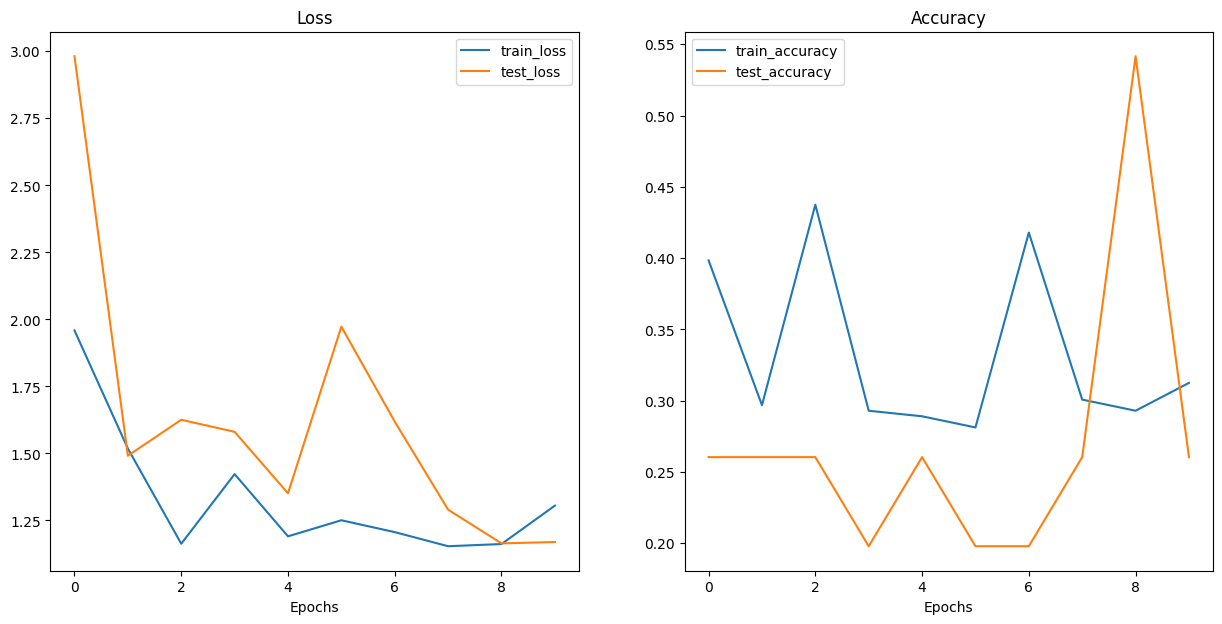

In [67]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained ViT from `torchvision.models`

Generally in deep learning, if you can use a pretrained model from a large dataset on your own problem. it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model?

* Sometimes data is limited.
* Limited training resources.
* Get better results faster (sometimes)...

In [68]:
# Cost of a TPUv3 for 30 days
cost = 30*24*8
print(f"Cost of renting TPUv3 for 30 straight days in {cost} USD")

Cost of renting TPUv3 for 30 straight days in 5760 USD


In [69]:
# The following torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it into a feature extractor).

In [71]:
# Get pretrained models for ViT
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT = best availbale"

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 231MB/s]


In [72]:
# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [73]:
from torchinfo import summary

# Get a summary using torchinfo summary
summary(model = pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained Vit model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

* https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html


In [74]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [75]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size = 32) # Could set a higher batch size because using a pretrained model

### 10.4 Train feature extractor ViT model

In [76]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5436 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1243 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2341 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2267 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2063 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor transformer model

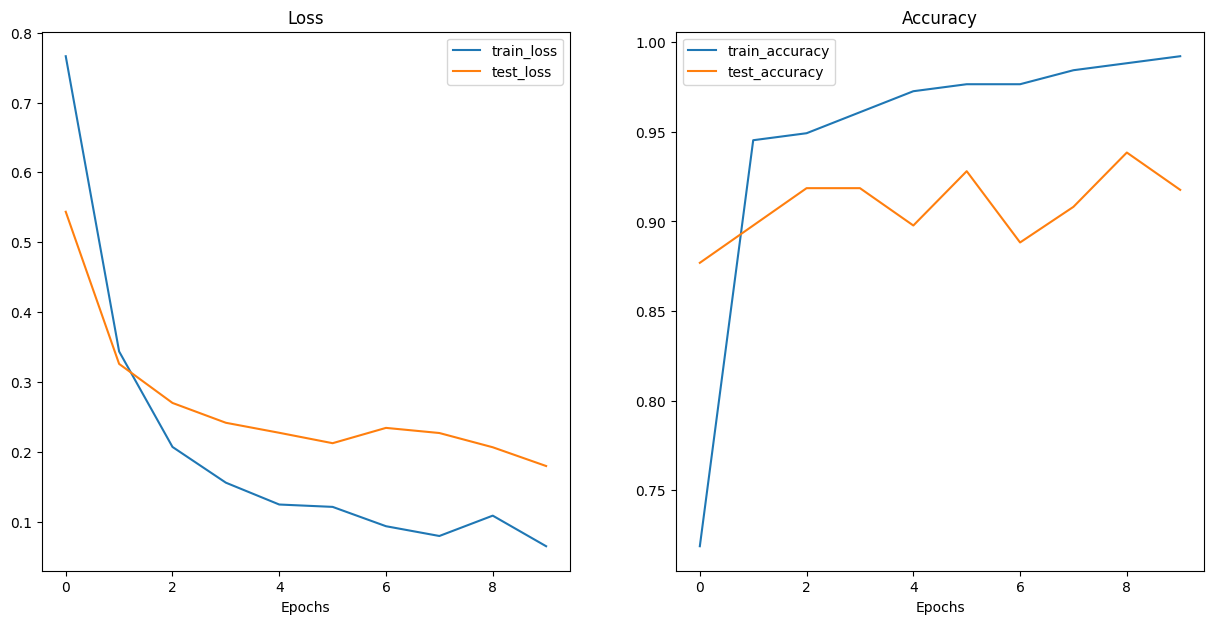

In [77]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and then check it's filesize

We want to check the filesize because fi we wanted to deploy a model to say a website/mobile application, we may have
limitations on the size of the model we can deploy

E.g a smaller model may be required due to compute restrictions

In [79]:
# Save the model
from going_modular.going_modular import utils

model_name_str = "08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth"

utils.save_model(model = pretrained_vit,
                target_dir = "models",
                model_name = model_name_str)

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [82]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/" + model_name_str).stat().st_size // (1024 * 1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is 11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.h: hard to deploy such a large file/might not make predictions as fast a smaller model).

### 11. Predicting on a custom image

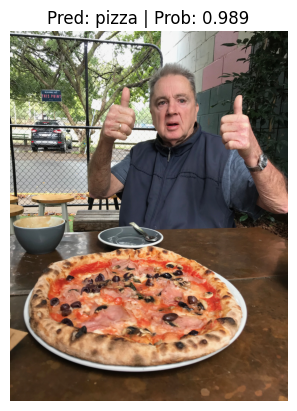

In [83]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)